**Network Dataset is created using 3 substations and 14 buildings with distribution line assumed to connect the substation to the naval facilities building**

This is the sample nodes which is the substations around the naval facilities.

In [6]:
import geopandas as gpd
import pandas as pd

# View nodes shapefile
nodes = gpd.read_file("epn_nodes_updated.shp")
nodes.head()

,nodenwid,fltytype,strctype,utilfcltyc,flow,guid,indpnode,geometry
0,1,1,0,EPP1,0.0,bc06cc34-b03a-4ce9-b6e2-e22e5fb78776,1,POINT (-76.49102 38.99094)
1,2,2,0,ESS3,0.0,f64962a9-b70d-4bd8-a743-81beaaf033ab,0,POINT (-76.5015 38.9793)
2,3,3,0,EDC1,0.0,8ae2a81d-8b82-4b09-94d3-9f71beabc20f,0,POINT (-76.4919 38.9609)


This is the sample links which is the connection from the substations to the buildings in the naval facilities.

In [7]:
# View link shapefile
links1 = gpd.read_file("epn_links_matched.shp")
(links1.head())

,linknw_id,fromnode,tonode,direction,pipetype,length_km,capacity,guid,linetype,geometry
0,1,2,101,0,1,0.0,0.0,2e0c3465-fcaf-4024-ab23-8287fce483d2,distribution,"LINESTRING (-76.5015 38.9793, -76.486 38.9802)"
1,2,2,102,0,1,0.0,0.0,e4f82b26-e6c4-4381-a355-bf2c4e841b6e,distribution,"LINESTRING (-76.5015 38.9793, -76.48568 38.97993)"
2,3,3,103,0,1,0.0,0.0,8d5877c4-614c-4358-a47c-311160d1f2d2,distribution,"LINESTRING (-76.4919 38.9609, -76.48535 38.97972)"
3,4,3,104,0,1,0.0,0.0,763e3cbf-7916-4173-9ffa-11d3eb2af041,distribution,"LINESTRING (-76.4919 38.9609, -76.48506 38.9795)"
4,5,3,105,0,1,0.0,0.0,46b7e8d8-9fff-4fa8-8293-d32155327425,distribution,"LINESTRING (-76.4919 38.9609, -76.48472 38.97929)"


This code reads the links and nodes shapefile to project it on Annapolis ESRI map.

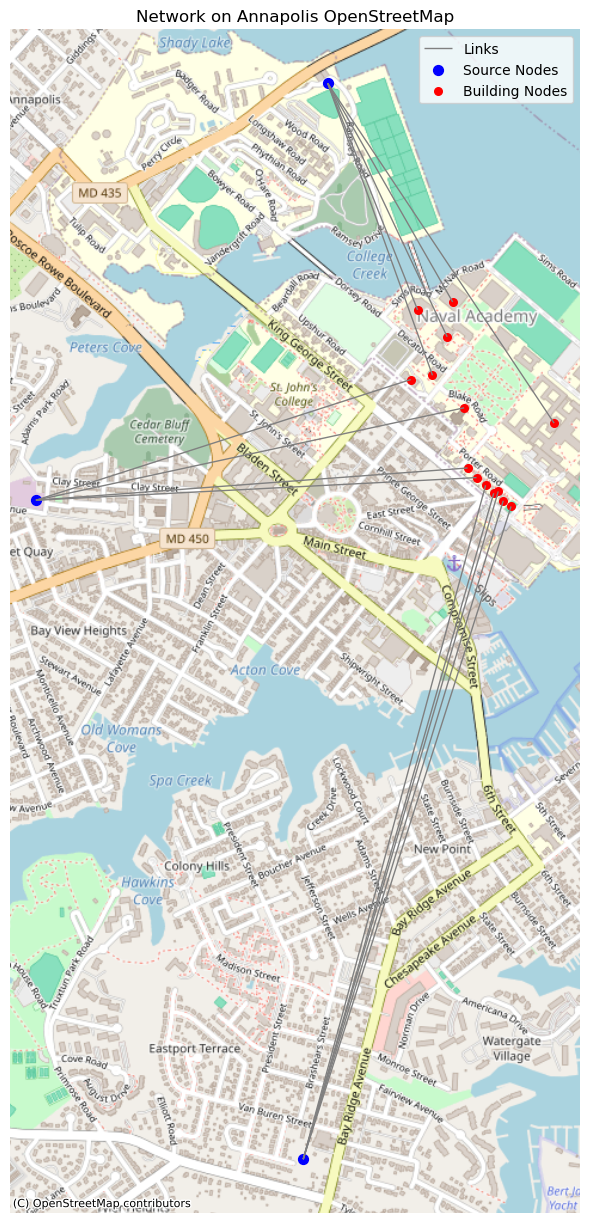

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Load source nodes and links
sources = gpd.read_file("epn_nodes_updated.shp")
links = gpd.read_file("epn_links_matched.shp")

# Extract building points (to-node endpoints from lines)
from shapely.geometry import Point

# Extract last coordinate from each LineString and convert to Point
to_node_coords = [Point(line.coords[-1]) for line in links.geometry]

building_points = gpd.GeoDataFrame(geometry=to_node_coords, crs="EPSG:4326") # converts the end point of the link to be a building directly. This can be replaced with actual building set too. 

# Convert all GeoDataFrames to Web Mercator (for basemap)
sources_web = sources.to_crs(epsg=3857)
links_web = links.to_crs(epsg=3857)
buildings_web = building_points.to_crs(epsg=3857)

# Plot with contextily basemap
fig, ax = plt.subplots(figsize=(6, 20))

links_web.plot(ax=ax, color="gray", linewidth=1, label="Links")
sources_web.plot(ax=ax, color="blue", markersize=50, label="Source Nodes")
buildings_web.plot(ax=ax, color="red", markersize=30, label="Building Nodes")

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.legend()
plt.title("Network on Annapolis OpenStreetMap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("off")
plt.tight_layout()
plt.show()


This code is used to edit the number, location of the nodes and the building locations which will edit the nodes and links shapefile automatically. We can also specify which building is connected to which substation and simulate scenarios accordingly. 

In [5]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import uuid

# === Step 1: Define source nodes ===
sources = gpd.GeoDataFrame({
    "node_id": [1, 2, 3],
    "geometry": [
        Point(-76.49102, 38.99094),
        Point(-76.5015, 38.9793),
        Point(-76.4919, 38.9609)
    ]
}, geometry="geometry", crs="EPSG:4326")

# === Step 2: Building data with fromnode assignments ===
data = {
    "ID": list(range(1, 15)),
    "Latitude": [
        38.980200, 38.979932, 38.979717, 38.979495, 38.979286,
        38.979127, 38.979546, 38.981453, 38.982788, 38.983863,
        38.984614, 38.982669, 38.981880, 38.984835
    ],
    "Longitude": [
        -76.485999, -76.485676, -76.485350, -76.485058, -76.484716,
        -76.484436, -76.484895, -76.482890, -76.487257, -76.486731,
        -76.487793, -76.488039, -76.486122, -76.486532
    ],
    "fromnode": [2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 1] # This specifies the substation from which the corresponding building receives power from.  
}
df = pd.DataFrame(data)
df["geometry"] = df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
buildings_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
buildings_gdf["tonode"] = buildings_gdf["ID"] + 100

# === Step 3: Create links ===
def get_source_geometry(node_id):
    return sources.loc[sources["node_id"] == node_id].geometry.values[0]

links_df = gpd.GeoDataFrame({
    "linknw_id": range(1, len(buildings_gdf) + 1),
    "fromnode": buildings_gdf["fromnode"],
    "tonode": buildings_gdf["tonode"],
    "direction": 0,
    "pipetype": 1,
    "length_km": 0.0,
    "capacity": 0.0,
    "guid": [str(uuid.uuid4()) for _ in range(len(buildings_gdf))],
    "linetype": "distribution",  # can be distribution or transmission
    "geometry": [
        LineString([get_source_geometry(fn), pt])
        for fn, pt in zip(buildings_gdf["fromnode"], buildings_gdf["geometry"])
    ]
}, geometry="geometry", crs="EPSG:4326")

# === Step 4: Save outputs ===
links_df.to_file("epn_links_matched.shp") # change name here to preserve original shape file
links_df[["fromnode", "tonode", "linknw_id"]].to_csv("network_graph.csv", index=False) # change name here to preserve original shape file


# === Step 5: Save node shapefile ===
# Create attribute table matching your node schema
node_df = gpd.GeoDataFrame({
    "nodenwid": sources["node_id"],
    "fltytype": [1, 2, 3],               # example facility types can be 1,2,3
    "strctype": 0,
    "utilfcltyc": ["EPP1", "ESS3", "EDC1"],  # example utility facility codes  can be "EPP1"","ESS3", "EDC1"
    "flow": 0.0,
    "guid": [str(uuid.uuid4()) for _ in range(len(sources))],
    "indpnode": [1, 0, 0],               # use 1 independent node and the others can be dependant nodes 
    "geometry": sources.geometry
}, geometry="geometry", crs="EPSG:4326")

# Save to file
node_df.to_file("epn_nodes_updated.shp") # change name here to preserve original shape file

print("✅ Link shapefile created with matched columns.")


✅ Link shapefile created with matched columns.


In [4]:
nodes.head()

,nodenwid,fltytype,strctype,utilfcltyc,flow,guid,indpnode,geometry
0,1,0,0,EPP1,0.0,5dc6b746-a576-44e3-9a64-6212ce552ea5,1,POINT (-76.49102 38.99094)
1,2,0,0,ESS3,0.0,fb7d500e-8242-4d3b-a5cd-f7c55db1d943,0,POINT (-76.5015 38.9793)
2,3,0,0,EDC1,0.0,1602884b-30da-4698-b6aa-ab529afe443b,0,POINT (-76.4919 38.9609)
